In [3]:
!pip install yfinance keras matplotlib scikit-learn
!pip install ace_tools


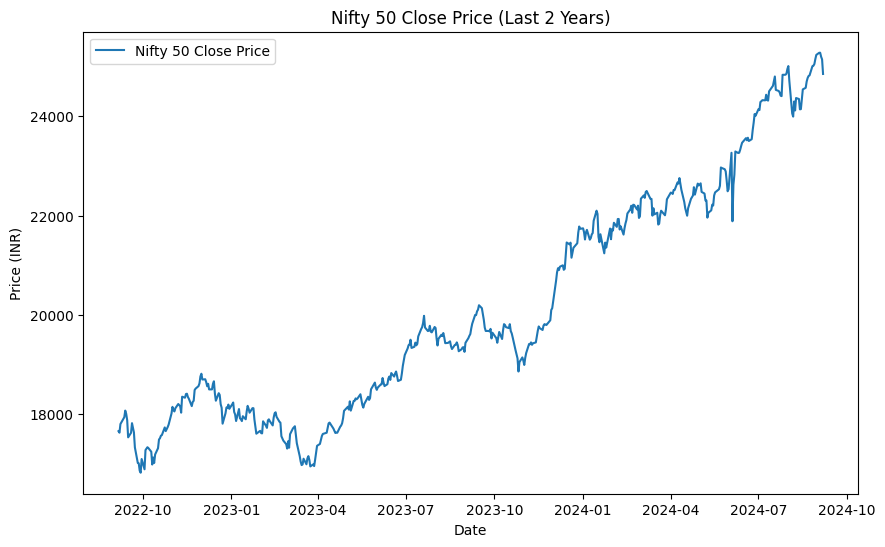

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0566 - val_loss: 0.0182
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0063 - val_loss: 0.0175
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0040 - val_loss: 0.0089
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0011 - val_l

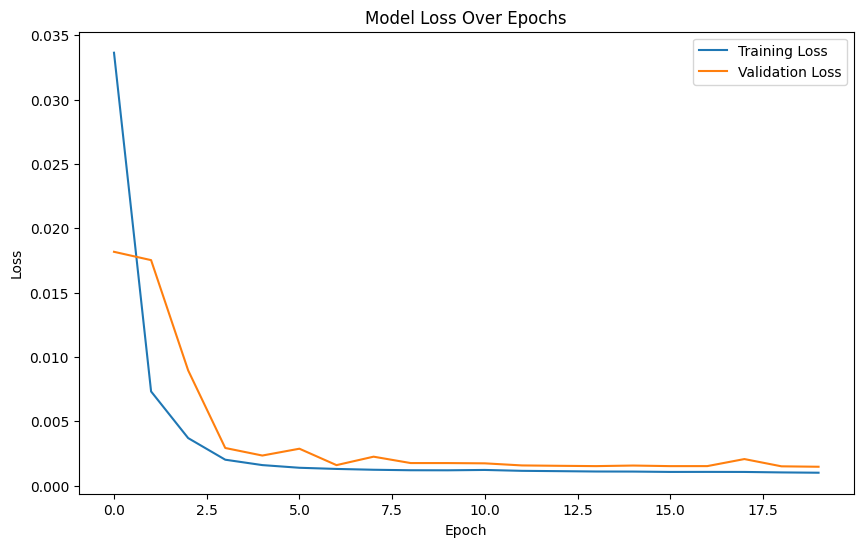

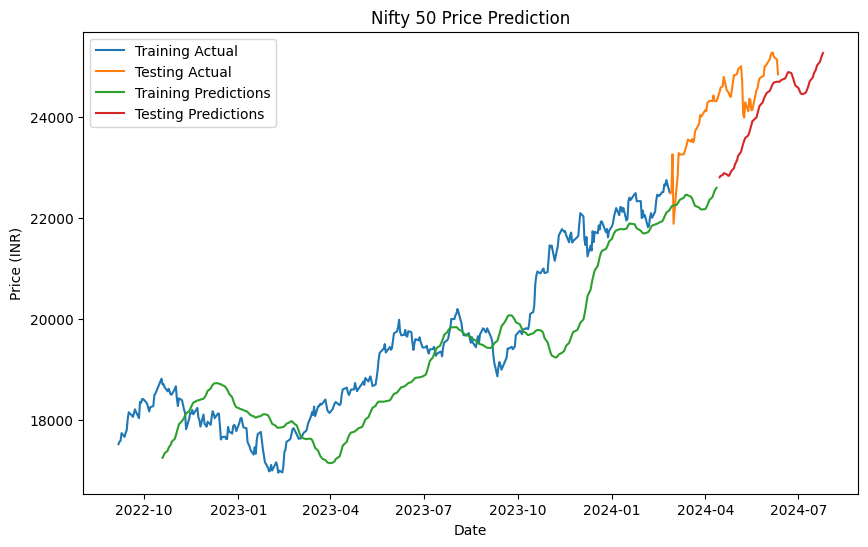

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Fetch Nifty 50 data for the past 2 years
nifty50 = yf.Ticker("^NSEI")  # Index - Nifty50's ticker symbol for NSE
data = nifty50.history(period="2y")  # Increase the data period to 2 years

# Check if the data is empty and handle the error
if data.empty:
    print("Error: Unable to fetch data from Yahoo Finance. Please check your internet connection and the ticker symbol.")
else:
    # Prepare the data for the prediction model
    data['Date'] = data.index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Visualizing the closing price
    plt.figure(figsize=(10, 6))
    plt.plot(data['Close'], label='Nifty 50 Close Price')
    plt.title('Nifty 50 Close Price (Last 2 Years)')
    plt.xlabel('Date')
    plt.ylabel('Price (INR)')
    plt.legend()
    plt.show()

    # Prepare the closing price data for training
    df = data[['Close']].values

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)

    # Define training data (80% train, 20% test)
    train_size = int(len(scaled_data) * 0.8)
    train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

    # Create datasets with time steps
    def create_dataset(dataset, time_step=1):
        X, Y = [], []
        for i in range(len(dataset) - time_step):
            X.append(dataset[i:(i + time_step), 0])
            Y.append(dataset[i + time_step, 0])
        return np.array(X), np.array(Y)

    time_step = 30  # Reduced from 60 to 30 to avoid data size issues
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # Reshape input to be [samples, time steps, features] for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model with more epochs and larger batch size
    history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test))

    # Predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Inverse transform the predictions back to original values
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    # Inverse transform actual values back to original values
    y_train_actual = scaler.inverse_transform([y_train])
    y_test_actual = scaler.inverse_transform([y_test])

    # Calculate Root Mean Squared Error (RMSE)
    train_rmse = math.sqrt(mean_squared_error(y_train_actual[0], train_predict[:, 0]))
    test_rmse = math.sqrt(mean_squared_error(y_test_actual[0], test_predict[:, 0]))

    print(f'Training RMSE: {train_rmse}')
    print(f'Testing RMSE: {test_rmse}')

    # Plot training & validation loss values
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot the predictions along with actual values
    plt.figure(figsize=(10, 6))
    plt.plot(data.index[:len(y_train_actual[0])], y_train_actual[0], label='Training Actual')
    plt.plot(data.index[len(y_train_actual[0]):len(y_train_actual[0]) + len(y_test_actual[0])], y_test_actual[0], label='Testing Actual')
    plt.plot(data.index[time_step:len(y_train_actual[0]) + time_step], train_predict, label='Training Predictions')  # Changed this line
    plt.plot(data.index[len(y_train_actual[0]) + time_step:len(y_train_actual[0]) + time_step + len(test_predict)], test_predict, label='Testing Predictions')  # Changed this line
    plt.title('Nifty 50 Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price (INR)')
    plt.legend()
    plt.show()


In [7]:
# Get the actual and predicted values for the last 5 days in the test set
last_5_actual = y_test_actual[0][-5:]  # Last 5 actual values
last_5_predicted = test_predict[-5:]  # Last 5 predicted values

# Extract the last 5 dates from the test set index
last_5_dates = data.index[-len(test_predict):][-5:]  # Last 5 dates

# Calculate the difference between actual and predicted values
difference = last_5_actual.flatten() - last_5_predicted.flatten()

# Format the dates to show "YYYY-MM-DD (Day)"
formatted_dates = last_5_dates.strftime('%Y-%m-%d (%A)')

# Create a DataFrame to display the values clearly
df_last_5 = pd.DataFrame({
    'Date': formatted_dates,
    'Actual': last_5_actual.flatten(),
    'Predicted': last_5_predicted.flatten(),
    'Difference': difference
})

# Display the DataFrame in Colab
print(df_last_5)


                     Date        Actual     Predicted  Difference
0     2024-09-02 (Monday)  25278.699219  25023.392578  255.306641
1    2024-09-03 (Tuesday)  25279.849609  25100.728516  179.121094
2  2024-09-04 (Wednesday)  25198.699219  25172.525391   26.173828
3   2024-09-05 (Thursday)  25145.099609  25231.345703  -86.246094
4     2024-09-06 (Friday)  24852.150391  25274.560547 -422.410156


In [9]:
import pandas as pd
import numpy as np

# Get the last 30 days from the test set to start predicting future prices
last_30_days = test_data[-time_step:]  # Last 30 days of data from the test set

# Reshape it to match the LSTM input shape [samples, time steps, features]
last_30_days = last_30_days.reshape(1, time_step, 1)

# List to store predicted values
future_predictions = []

# Predict the next 5 valid trading days (skip weekends)
days_predicted = 0
current_date = pd.Timestamp(data.index[-1])

# Keep predicting until we have 5 future trading days (skip weekends)
while days_predicted < 5:
    # Check if the current date is a weekday (Monday=0, Sunday=6)
    if current_date.weekday() < 5:  # 0-4 are weekdays
        # Predict the next day
        next_predicted = model.predict(last_30_days)

        # Append the prediction to the list
        future_predictions.append(next_predicted[0][0])

        # Update the input data by adding the predicted value and removing the oldest value
        new_input = np.append(last_30_days[0][1:], next_predicted[0][0])

        # Reshape the input back to the shape [1, time steps, features]
        last_30_days = new_input.reshape(1, time_step, 1)

        # Increase the day counter only for trading days
        days_predicted += 1

    # Move to the next day (whether it's a weekend or weekday)
    current_date += pd.DateOffset(1)

# Inverse transform the predicted values to get the actual scale
future_predictions_actual = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Generate future dates, excluding weekends
future_dates = pd.bdate_range(start=data.index[-1], periods=5).strftime('%Y-%m-%d (%A)')

# Create a DataFrame with the predicted values and dates
df_future_predictions = pd.DataFrame({
    'Date': future_dates,
    'Predicted': future_predictions_actual.flatten()
})

# Display the future predictions
print(df_future_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
                     Date     Predicted
0     2024-09-06 (Friday)  25287.011719
1     2024-09-09 (Monday)  25304.384766
2    2024-09-10 (Tuesday)  25324.302734
3  2024-09-11 (Wednesday)  25346.138672
4   2024-09-12 (Thursday)  25369.365234


In [10]:
# Print RMSE results
print(f'Training RMSE: {train_rmse}')
print(f'Testing RMSE: {test_rmse}')

# Disclaimer
print("\nDisclaimer: The predictions provided by this model are for informational purposes only.")
print("The model is based on historical data and patterns, and future stock prices may not follow these patterns.")
print("Please consult a financial expert before making any investment decisions. The model's performance is not a guarantee of future results.")


Training RMSE: 258.88960726368913
Testing RMSE: 323.2844075225547

Disclaimer: The predictions provided by this model are for informational purposes only.
The model is based on historical data and patterns, and future stock prices may not follow these patterns.
Please consult a financial expert before making any investment decisions. The model's performance is not a guarantee of future results.


**End of the program**